# How Much Time Have I Spent Watching Schitt's Creek?

## Introduction

This is a question that has run through my head repeatedly over the years. The beloved sitcom has been my top "comfort show/background noise" choice since its inception.

Netflix allows you to download a veritable treasure-trove of data about your account, and, with just a little bit of programming, I can now get a concrete answer to the question: how much time have I spent watching Schitt's Creek?

## Objective

My goal for this project is to analyze Netflix data to help me understand my viewing habits. Possible questions to be answered:

- How much time have I spent watching Schitt's Creek?
- When do I watch Schitt's Creek? 
- What day of the week do I watch Schitt's Creek the most? 
- Which hours did I watch Schitt's Creek the most?
- Visualize my viewing habits 

## Get Data

Netflix allows you to download reports on your data. To get the data, I used this [link](https://www.netflix.com/account/getmyinfo).

## Underst Data

After requesting my data from Netflix, you recieve a zip folder that looks like this: 

<img src="zip.png"> 

The goal here is to figure out how much time I've spent watching Netflix. `Content Interaction` holds the data we're looking for, saved as a CSV called `ViewingActivity.csv`. Here's a screenshot sample of what my data looks like:

<img src="sample.png">

Looking at the data, I can quickly spot one potential challenge. There's a single column, Title, that holds both show and episode titles, so I'll need to do a little extra work to filter for only episodes of Schitt's Creek.

Diving deeper, in the downloaded zip file, there's a file called `Cover sheet.pdf` that contains data dictionaries for all of the .csv files, including `ViewingActivity.csv`.

This data dictionary can help us answer questions and avoid errors. For example, consulting the dictionary for ViewingActivity.csv, we can see that the column `Start Time` uses the UTC timezone. To analyze which times of day I most often watch Netflix, I'll need to convert this column to my local timezone.

## Load Data

In [15]:
import pandas as pd

df = pd.read_csv('ViewingActivity.csv')

In [17]:
df.shape

(6088, 10)

I have 27,353 rows and 10 columns in my dataset. 

In [18]:
df.head()

,Profile Name,Start Time,Duration,Attributes,Title,Supplemental Video Type,Device Type,Bookmark,Latest Bookmark,Country
0,Angelica,2021-01-24 21:19:10,00:00:33,Autoplayed: user action: None;,Peppermint_hook_primary_16x9,HOOK,Apple iPhone XR,00:00:33,00:00:33,US (United States)
1,Angelica,2021-01-24 21:18:30,00:00:22,Autoplayed: user action: None;,The Foreigner_hook_primary_16x9,HOOK,Apple iPhone XR,00:00:23,00:00:23,US (United States)
2,Angelica,2021-01-24 21:18:03,00:00:24,Autoplayed: user action: None;,Homefront_hook_primary_16x9,HOOK,Apple iPhone XR,00:00:24,00:00:24,US (United States)
3,Angelica,2021-01-23 08:04:00,00:15:59,Autoplayed: user action: Unspecified;,The White Tiger,NaN,LG 2019 RTK K5Lp Standard UHD TV Smart TV,00:16:18,00:16:18,US (United States)
4,Angelica,2021-01-23 07:43:20,00:00:05,Autoplayed: user action: None;,Trailer: The White Tiger,TRAILER,LG 2019 RTK K5Lp Standard UHD TV Smart TV,00:00:05,00:00:05,US (United States)


# Clean Data

## Dropping Unnecessary Columns

I'll start by dropping the columns I'm not planning to use. I like to work with a dataframe that includes only columns I'll actually use while working on smaller projects. 

I plan to analyze how much and when I've watched Schitt's Creek, so I'll need to keep the `Start Time`, `Duration`, and `Title` columns. Everything else can go.

In [20]:
df = df.drop(['Profile Name', 'Attributes', 'Supplemental Video Type', 'Device Type', 'Bookmark', 'Latest Bookmark', 'Country'], axis=1)
df.head(1)

,Start Time,Duration,Title
0,2021-01-24 21:19:10,00:00:33,Peppermint_hook_primary_16x9


## Convert Strings to Datetime and Timedelta in Pandas

### Start Time

While the data in `Start Time` and `Duration` columns look correct, I'll double check to see what data types I'm working with.

In [24]:
df.dtypes

Start Time    object
Duration      object
Title         object
dtype: object

All three columns are stored as `object`, which means they're `strings`. I'll change the two time-related columns into the correct datatypes.

In [25]:
df['Start Time'] = pd.to_datetime(df['Start Time'], utc=True)
df.dtypes

Start Time    datetime64[ns, UTC]
Duration                   object
Title                      object
dtype: object

Now that I have `Start Time` in the correct format, I'll convert the timezone to US/Pacific. 

In [28]:
# change the Start Time column into the dataframe's index (we can only use .tz_convert() on a DatetimeIndex, so 
# we need to set our Start Time column as the index using set_index() before we perform the conversion.)
df = df.set_index('Start Time')

# convert from UTC timezone to Pacific time
df.index = df.index.tz_convert('US/Pacific')

# reset the index so that Start Time becomes a column again
df = df.reset_index()

# double-check that it worked
df.head(1)

,Start Time,Duration,Title
0,2021-01-24 13:19:10-08:00,00:00:33,Peppermint_hook_primary_16x9


This is correct, because the previous first row in our dataset had a `Start Time` of 2021-01-24 21:19:10. During Daylight Savings Time, the U.S. Pacific time zone is eight hours behind UTC, so we can see that our conversion has executed correctly!

### Duration

The duration suggests a measure of a length of time. I'll convert it to a timedelta, which is a measure of time duration that pandas understands.

In [30]:
df['Duration'] = pd.to_timedelta(df['Duration'])
df.dtypes

Start Time    datetime64[ns, US/Pacific]
Duration                 timedelta64[ns]
Title                             object
dtype: object

## Filtering Title Column

I need to filter the `Title` column so that I can analyze only views of Schitt's Creek. I'm going to create a new dataframe called `schitts` and populate it only with rows where the `Title` column contains 'Schitt'.

In [41]:
# create a new dataframe called Schitts that takes from df
# only the rows in which the Title column contains 'Schitt's Creek'
schitts = df[df['Title'].str.contains('Schitt', regex=False)]


In [44]:
schitts.shape

(161, 3)

## Filter Out Short Durations

I noticed in my data exploration that when something like an episode preview auto-plays on the homepage, it counts as a view in our data.

However, watching two seconds of a trailer as you scroll past isn't the same as actually watching an episode! I'll filter our `schitts` dataframe down a little bit further by limiting it to only rows where the Duration value is greater than one minute. This should effectively count the watchtime for partially watched episodes, while filtering out those short, unavoidable "preview" views.

In [46]:
schitts = schitts[(schitts['Duration'] > '0 days 00:01:00')]
schitts.shape

(139, 3)

# Analyzing the Data

## How much time have I spent watching Schitt's Creek?

In [47]:
schitts['Duration'].sum()

Timedelta('1 days 18:56:22')

## When do I watch Schitt's Creek?

In [67]:
# to bypass chained indexing warning
pd.set_option('mode.chained_assignment', None) 

schitts['weekday'] = schitts['Start Time'].dt.weekday
schitts['hour'] = schitts['Start Time'].dt.hour

# check to make sure the columns were added correctly
schitts.head(1)

,Start Time,Duration,Title,weekday,hour
705,2020-12-19 01:04:50-08:00,00:07:55,Schitt's Creek: Season 2: Estate Sale (Episode 4),5,1


In [52]:
%matplotlib inline
import matplotlib

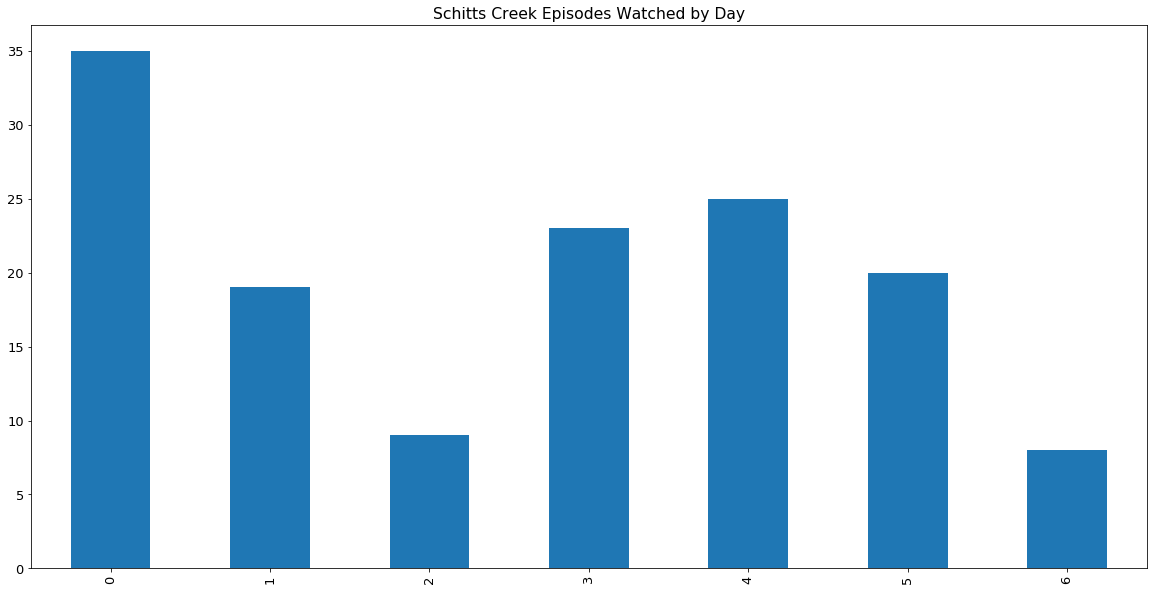

In [69]:
# to bypass chained indexing warning
pd.set_option('mode.chained_assignment', None)

# set our categorical and define the order so the days are plotted Monday-Sunday
schitts['weekday'] = pd.Categorical(schitts['weekday'], categories=
    [0,1,2,3,4,5,6],
    ordered=True)

# create office_by_day and count the rows for each weekday, assigning the result to that variable
schitts_by_day = schitts['weekday'].value_counts()

# sort the index using our categorical, so that Monday (0) is first, Tuesday (1) is second, etc.
schitts_by_day = schitts_by_day.sort_index()

# optional: update the font size to make it a bit larger and easier to read
matplotlib.rcParams.update({'font.size': 13})

# plot office_by_day as a bar chart with the listed size and title
schitts_by_day.plot(kind='bar', figsize=(20,10), title='Schitts Creek Episodes Watched by Day')


I've tended to watch Schitt's Creek more during the week than on weekends.

Now, let's take a look at the same data by hour. The process here is very similar to what we just did above:

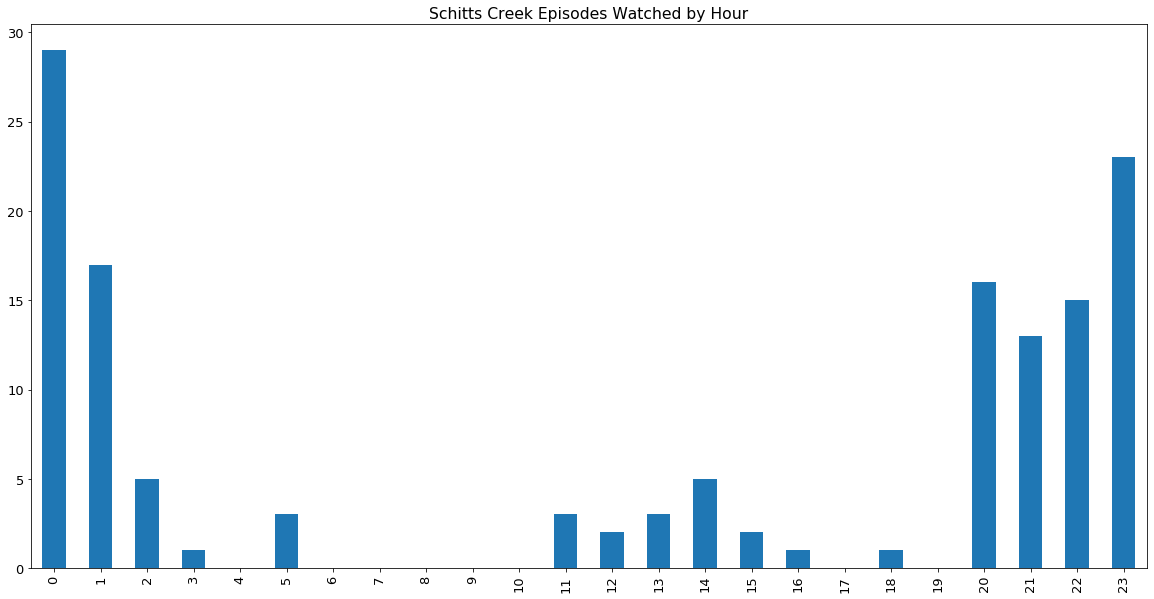

In [71]:
# to bypass chained indexing warning
pd.set_option('mode.chained_assignment', None)

# set our categorical and define the order so the hours are plotted 0-23
schitts['hour'] = pd.Categorical(schitts['hour'], categories=
    [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23],
    ordered=True)

# create office_by_hour and count the rows for each hour, assigning the result to that variable
schitts_by_hour = schitts['hour'].value_counts()

# sort the index using our categorical, so that midnight (0) is first, 1 a.m. (1) is second, etc.
schitts_by_hour = schitts_by_hour.sort_index()

# plot office_by_hour as a bar chart with the listed size and title
schitts_by_hour.plot(kind='bar', figsize=(20,10), title='Schitts Creek Episodes Watched by Hour')

From the data, it looks like 11 p.m. to 1 a.m. were the hours during which I most often started episodes of Schitt's Creek. This is due to my (unhealthy) habit of using the show as white noise while going to sleep — many of these episodes probably auto-played while I was already asleep!

Outside of that, it's no surprise to see that most of my viewing happened during the evenings.

# Conclusion

I've taken a quick dive into some personal Netflix data and learned that — among other things — I watch Schitt's Creek too much.